In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
import fitsio

from astropy.io import fits
from astropy import wcs

import healpy as hp

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
randoms_columns = ['RA', 'DEC', 'MASKBITS', 'WISEMASK_W1', 'NOBS_G', 'NOBS_R', 'NOBS_Z', 'PHOTSYS', 'BRICKID', 'GALDEPTH_G']

randoms_paths = sorted(glob.glob('/global/cfs/cdirs/desi/target/catalogs/dr9/0.49.0/randoms/resolve/randoms-[0-9]*.fits'))
print(len(randoms_paths))

randoms_stack = []
for randoms_path in randoms_paths[:5]:
    
    print(randoms_path)
    
    hdu = fits.open(randoms_path)
    randoms = Table()
    for col in randoms_columns:
        randoms[col] = np.copy(hdu[1].data[col])

    mask = hp.ang2pix(8, randoms['RA'], randoms['DEC'], nest=True, lonlat=True)==97
    randoms = randoms[mask]
    
    randoms_stack.append(randoms)

randoms = vstack(randoms_stack)

200


In [4]:
cat = randoms

In [5]:
field = 'south'
mask = cat['PHOTSYS']=='S'
cat = cat[mask]

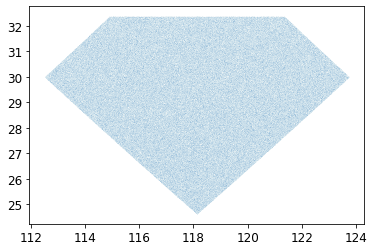

In [6]:
plt.plot(cat['RA'], cat['DEC'], '.' , ms=0.1, alpha=0.1)

In [7]:
field = 'south'

bricks = Table(fitsio.read('/global/cfs/cdirs/cosmo/data/legacysurvey/dr9/survey-bricks.fits.gz'))
print(len(bricks))

662174


In [8]:
# Initialize the columns

# rounding before converting to integers
cat['C_WISEMASK_W1'] = 0
cat['C_MASKBITS'] = 0
cat['C_NOBS_G'] = 0
cat['C_NOBS_R'] = 0
cat['C_NOBS_Z'] = 0
cat['C_GALDEPTH_G'] = 0.

# as done for randoms
cat['C1_WISEMASK_W1'] = 0
cat['C1_MASKBITS'] = 0
cat['C1_NOBS_G'] = 0
cat['C1_NOBS_R'] = 0
cat['C1_NOBS_Z'] = 0
cat['C1_GALDEPTH_G'] = 0.

In [12]:
# Randomly select some bricks to check

brickid_list = [507224, 494841, 492327, 483436, 483438, 507226, 488533, 479597,
       484718, 496090, 479586, 504756, 491077, 497354, 493593, 499833,
       479582, 504754, 478290, 496087, 488547, 492326, 507203, 489810,
       501082, 504759, 496086, 480872, 494835, 479581, 494838, 499820,
       488549, 496107, 475706, 480869, 480877, 480874, 489815, 492344,
       505999, 502303, 492333, 497355, 488545, 482152, 501066, 505980,
       506000, 497339, 475703, 498597, 497334, 470500, 493581, 491075,
       496089, 496081, 502316, 498572, 504753, 493587, 503528, 497338,
       503526, 503529, 482162, 477009, 487276, 482150, 501080, 498571,
       503530, 492317, 498594, 494851, 489811, 488534, 491059, 494837,
       498595, 493590, 479589, 491078, 488537, 503535, 501062, 480868,
       497328, 498570, 484729, 485985, 487275, 496110, 499830, 488540,
       486003, 501054, 484730, 494828]
mask = np.in1d(cat['BRICKID'], brickid_list)
cat = cat[mask]

In [13]:
for index, brickid in enumerate(np.unique(cat['BRICKID'])):
    
    print(index)
    
    cat_mask = cat['BRICKID']==brickid
    
    mask = bricks['BRICKID']==brickid
    brick_index = np.where(mask)[0][0]
        
    brickname = str(bricks['BRICKNAME'][brick_index])
    img_fn = '/global/cfs/cdirs/cosmo/data/legacysurvey/dr9/{}/coadd/{}/{}/legacysurvey-{}-maskbits.fits.fz'.format(field, brickname[:3], brickname, brickname)
    nexp_g_fn = '/global/cfs/cdirs/cosmo/data/legacysurvey/dr9/{}/coadd/{}/{}/legacysurvey-{}-nexp-g.fits.fz'.format(field, brickname[:3], brickname, brickname)
    nexp_r_fn = '/global/cfs/cdirs/cosmo/data/legacysurvey/dr9/{}/coadd/{}/{}/legacysurvey-{}-nexp-r.fits.fz'.format(field, brickname[:3], brickname, brickname)
    nexp_z_fn = '/global/cfs/cdirs/cosmo/data/legacysurvey/dr9/{}/coadd/{}/{}/legacysurvey-{}-nexp-z.fits.fz'.format(field, brickname[:3], brickname, brickname)
    galdepth_g_fn = '/global/cfs/cdirs/cosmo/data/legacysurvey/dr9/{}/coadd/{}/{}/legacysurvey-{}-galdepth-g.fits.fz'.format(field, brickname[:3], brickname, brickname)

    hdulist = fits.open(img_fn)
    w = wcs.WCS(hdulist[1].header)
    
    maskbits = fitsio.read(img_fn, ext='MASKBITS')
    wisem1 = fitsio.read(img_fn, ext='WISEM1')
    nexp_g = fitsio.read(nexp_g_fn)
    nexp_r = fitsio.read(nexp_r_fn)
    nexp_z = fitsio.read(nexp_z_fn)
    galdepth_g = fitsio.read(galdepth_g_fn)
    
    coadd_x, coadd_y = w.wcs_world2pix(cat['RA'][cat_mask], cat['DEC'][cat_mask], 0)
    coadd_x1, coadd_y1 = coadd_x.astype(int), coadd_y.astype(int)   # as done for randoms
    coadd_x, coadd_y = np.round(coadd_x).astype(int), np.round(coadd_y).astype(int)  # rounding before converting to integers
    cat['C_MASKBITS'][cat_mask] = maskbits[coadd_y, coadd_x]
    cat['C_WISEMASK_W1'][cat_mask] = wisem1[coadd_y, coadd_x]
    cat['C_NOBS_G'][cat_mask] = nexp_g[coadd_y, coadd_x]
    cat['C_NOBS_R'][cat_mask] = nexp_r[coadd_y, coadd_x]
    cat['C_NOBS_Z'][cat_mask] = nexp_z[coadd_y, coadd_x]
    cat['C_GALDEPTH_G'][cat_mask] = galdepth_g[coadd_y, coadd_x]
    cat['C1_MASKBITS'][cat_mask] = maskbits[coadd_y1, coadd_x1]
    cat['C1_WISEMASK_W1'][cat_mask] = wisem1[coadd_y1, coadd_x1]
    cat['C1_NOBS_G'][cat_mask] = nexp_g[coadd_y1, coadd_x1]
    cat['C1_NOBS_R'][cat_mask] = nexp_r[coadd_y1, coadd_x1]
    cat['C1_NOBS_Z'][cat_mask] = nexp_z[coadd_y1, coadd_x1]
    cat['C1_GALDEPTH_G'][cat_mask] = galdepth_g[coadd_y1, coadd_x1]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [14]:
len(cat)

74415

In [15]:
# rounding before converting to integers
print(np.all(cat['C_MASKBITS']==cat['MASKBITS']))
print(np.all(cat['C_WISEMASK_W1']==cat['WISEMASK_W1']))
print(np.all(cat['C_GALDEPTH_G']==cat['GALDEPTH_G']))

# as done in randoms.py
print(np.all(cat['C1_MASKBITS']==cat['MASKBITS']))
print(np.all(cat['C1_WISEMASK_W1']==cat['WISEMASK_W1']))
print(np.all(cat['C1_GALDEPTH_G']==cat['GALDEPTH_G']))

False
False
False
True
True
True


In [16]:
# rounding before converting to integers
print(np.sum(cat['C_MASKBITS']!=cat['MASKBITS']), np.sum(cat['C_MASKBITS']!=cat['MASKBITS'])/len(cat))
print(np.sum(cat['C_WISEMASK_W1']!=cat['WISEMASK_W1']), np.sum(cat['C_WISEMASK_W1']!=cat['WISEMASK_W1'])/len(cat))
print(np.sum(cat['C_GALDEPTH_G']!=cat['GALDEPTH_G']), np.sum(cat['C_GALDEPTH_G']!=cat['GALDEPTH_G'])/len(cat))

# as done in randoms.py
print(np.sum(cat['C1_MASKBITS']!=cat['MASKBITS']), np.sum(cat['C1_MASKBITS']!=cat['MASKBITS'])/len(cat))
print(np.sum(cat['C1_WISEMASK_W1']!=cat['WISEMASK_W1']), np.sum(cat['C1_WISEMASK_W1']!=cat['WISEMASK_W1'])/len(cat))
print(np.sum(cat['C1_GALDEPTH_G']!=cat['GALDEPTH_G']), np.sum(cat['C1_GALDEPTH_G']!=cat['GALDEPTH_G'])/len(cat))

254 0.00341329033125042
40 0.0005375260364173889
1054 0.0141638110595982
0 0.0
0 0.0
0 0.0


In [17]:
medium = cat['MASKBITS'] & 2**11>0
c_medium = cat['C_MASKBITS'] & 2**11>0
c1_medium = cat['C1_MASKBITS'] & 2**11>0

print(np.sum(medium!=c_medium), np.sum(medium!=c_medium)/len(cat))
print(np.sum(medium!=c1_medium), np.sum(medium!=c1_medium)/len(cat))

64 0.0008600416582678224
0 0.0
